In [159]:
import os
import csv
import nltk
import re
import operator
import math
import readability
import random
from nltk import word_tokenize
from gensim.models import Word2Vec
from numpy import array
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from numpy import array
from numpy import mean
from numpy import zeros
from nltk.tag import StanfordPOSTagger
from nltk.tag import StanfordNERTagger

# the directory containing the data
root_dir = 'clean_data/'

# the csv containing the class information 
csv_name = 'clean_data/clean.csv'

# May be necessary to uncomment for computers with Windows OS to access Java
# java_path = "C:/Program Files/Java/jdk1.8.0_144/bin"
# os.environ['JAVAHOME'] = java_path

# nltk.internals.config_java("C:/Program Files/Java/jdk1.8.0_144/bin", options='-Xmx3024m')

# POS tagger
st = StanfordPOSTagger('english-left3words-distsim.tagger', path_to_jar='stanford-postagger.jar')

# Named Entities tagger
ner = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz', 'stanford-ner.jar')

# Splits names of files in data directory into training and test files
def train_test_split(directory):
    file_names = os.listdir(directory)
    random.shuffle(file_names)
    train_list = []
    test_list = []
    i = 0
    for file_name in file_names:
        if file_name != '.DS_Store':
            if i < 4:
                train_list.append(file_name)
                i+= 1
            else:
                test_list.append(file_name)
                i = 0
    return (train_list, test_list)

# Creates training dictionaries for training files in data directory
def make_training_dicts(filepath, file_list):
    age_dir = {}
    time_dir = {}
    with open(filepath, encoding='latin-1') as file:
        reader = csv.reader(file)
        for row in reader:
            if row[0] in file_list:
                age_dir[row[0]] = row[1]
                time_dir[row[0]] = row[2]
    return (age_dir, time_dir)

# Takes plaintext file of novel and cleans/tokenizes it
def clean_and_tokenize_file(file_name):
    file = open(file_name, encoding='latin-1')
    raw_text = file.read()
    raw_text_lower = raw_text.lower()
    caseless_tokens = nltk.word_tokenize(raw_text_lower)
    caseless_tokens = [x for x in caseless_tokens if re.match('\w+', x)]
    sentences = nltk.sent_tokenize(raw_text_lower)
    raw_sentence_tokens = nltk.sent_tokenize(raw_text)
    case_tokens = nltk.word_tokenize(raw_text)
    sentence_list = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        sentence_list.append([x for x in words if re.match('\w+', x)])
    return (caseless_tokens, sentence_list, raw_sentence_tokens, case_tokens)

# Goes through every plaintext novel file in directory and cleans/tokenizes it
def clean_and_tokenize_corpus(directory, file_list):
    file_dir = {}
    for file_name in os.listdir(directory):
        if file_name in file_list:
            file_dir[file_name] = clean_and_tokenize_file(directory + file_name)
    return file_dir

# Counts vocabulary of words in corpus
def count_total_vocab(file_wordfreqs):
    vocab = {}
    for words in file_wordfreqs:
        for word in words:
            if word in vocab:
                vocab[word] += 1
            else:
                vocab[word] = 1
    return vocab

# Removes words that fall under unknown threshhold from vocabulary dictionary and returns filtered dictionarys
def get_corpus_vocab(corpus, unknown_threshold):
    initial_dict = count_total_vocab(corpus)
    sorted_dict = sorted(initial_dict.items(), key=operator.itemgetter(1), reverse=True)
    filtered_dict = [key for key, value in sorted_dict[:unknown_threshold]]
    return filtered_dict

# Calculates tf-idf value for given corpus
def get_idf_dict(vocab, corpus):
    idf_dict = {}
    num_docs = len(corpus) 
    for word in vocab:
        df_count = 1
        for doc in corpus:
            if word in doc:
                df_count += 1
        idf_dict[word] = math.log(num_docs / df_count)
    return idf_dict

# Returns all named entities in given novel text file
def get_named_entities(novel):
    named_entities = ner.tag(novel)
    entities = []
    cur_entity = []
    last_tag = 'O'
    for entity in named_entities:
        if entity[1] == 'O':
            if len(cur_entity) > 0:
                new_entry = (' '.join(cur_entity), last_tag)
                if new_entry not in entities:
                    entities.append(new_entry)
                cur_entity = []
            last_tag = 'O'
        elif entity[1] == last_tag:
            cur_entity.append(entity[0])
        else:
            if len(cur_entity) > 0:
                new_entry = (' '.join(cur_entity), last_tag)
                if new_entry not in entities:
                    entities.append(new_entry)
                cur_entity = []
            cur_entity.append(entity[0])
            last_tag = entity[1]
    return entities

# Returns corpus containing named entity frequencies for given corpus
def get_ne_corpus(corpus):
    ne_dict = {}
    for key, value in corpus.items():
        ne_dict[key] = get_named_entities(value[3])
    return ne_dict

# (1) Split novel directory into training and test files
full_list = train_test_split(root_dir)
train_list = full_list[0]
test_list = full_list[1]
training_data = make_training_dicts(csv_name, train_list)
training_age = training_data[0]
training_time = training_data[1]
corpus = clean_and_tokenize_corpus(root_dir, train_list)

# (2) Define dictionaries for unigram, tf-idf, and named entity features for training data
ugram_corpus = [value[0] for key, value in corpus.items()]
vocab = get_corpus_vocab(ugram_corpus, 500)
idf_dict = get_idf_dict(vocab, ugram_corpus)
ne_corpus = get_ne_corpus(corpus)
ne_vals = [value for key, value in ne_corpus.items()]
ne_vocab = get_corpus_vocab(ne_vals, 100)
ne_idf_dict = get_idf_dict(ne_vocab, ne_vals)

# (3) Define dictionaries for unigram, tf-idf, and named entity features for test data
testing_data = make_training_dicts(csv_name, test_list)
testing_age = testing_data[0]
testing_time = testing_data[1]
test_corpus = clean_and_tokenize_corpus(root_dir, test_list)
test_ugram_corpus = [value[0] for key, value in test_corpus.items()]

test_idf_dict = get_idf_dict(vocab, test_ugram_corpus)
test_ne_corpus = get_ne_corpus(test_corpus)
test_ne_vals = [value for key, value in test_ne_corpus.items()]
test_ne_idf_dict = get_idf_dict(ne_vocab, test_ne_vals)
print('Finished corpus-wide work')

Finished corpus-wide work


In [166]:
# Function to train word2vector model on given corpus of unigrams
def train_word2vec(corpus):
    model = Word2Vec(corpus, size=100)
    model.train(corpus, total_examples=len(corpus), epochs=50)
    return model

word2vec = train_word2vec(ugram_corpus)
print('Finished word2vec training')

Finished word2vec training


In [167]:
import operator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# gets a list of stopwords from nltk
stop_words = set(stopwords.words('english')) 

# lemmatizes a text of unigrams using nltk's wordnetlemmatizer
def lemmatize_text(text):
    lemmatized = [WordNetLemmatizer().lemmatize(word) for word in text if word not in stop_words]
    return lemmatized

# lemmtizes a list of texts
def lemmatize_corpus(corpus):
    clean_texts = [lemmatize_text(text) for text in corpus]
    return clean_texts

# gets a gensim dictionary that gives each word in the corpus a unique id
def get_working_dict(corpus):
    return corpora.Dictionary(corpus)

# trains an lda topic model on a given corpus and word dictionary
def train_lda(lem_corpus, dictionary):
    corpus = [dictionary.doc2bow(text) for text in lem_corpus]
    lda_model = LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
    return lda_model

# trains topic model on our unigram corpus
lemmatized_corpus = lemmatize_corpus(ugram_corpus)
dictionary = get_working_dict(lemmatized_corpus)
lda_model = train_lda(lemmatized_corpus, dictionary)
print('Finished topic-model training')

Finished topic-model training


In [168]:
# Function to compile names of every feature in given feature directory
def create_name_feature_vector(is_time):
    tagset = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
    topic_list = []
    for i in range(10):
        topic_list.append('topic ' + str(i))
    init_list = vocab + tagset + ['w2v'] * 100 + topic_list
    init_list.append('vocab size')
    init_list.append('cs similarity')
    if is_time:
        time_list = init_list + ne_vocab
        time_list.append('flesch score')
        return time_list
    else:
        return init_list

# Retrieve array of time feature names
time_feature_names = create_name_feature_vector(True)

# Retrieve array of age feature names
age_feature_names = create_name_feature_vector(False)
print('Finished init vector names')
    

Finished init vector names


In [169]:
st.java_options = '-mx4g'

# Calculates tf-idf for given novel
def tf_idf(vocab, document, idf_dict):
    counts = Counter(document)
    doc_len = len(document)
    tf_idfs = []
    for word in vocab:
        doc_counter = 0
        tf = counts[word] / len(document)
        idf = idf_dict[word]
        tf_idfs.append(tf*idf)
    return tf_idfs

# Calculates word2vec for given novel
def get_avg_word2vec(novel):
    vec_list = []
    for word in novel:
        if word in word2vec:
            vec_list.append(word2vec[word])
    vector_array = array(vec_list)
    vector_array = mean(vector_array, axis=0)
    return vector_array.tolist()

# Retrieves average cosine-similarity between all sentences in given novel
def get_pairwise_similarity(sentences):
    sentence_vectors = []
    for sentence in sentences:
        vec_list = []
        for word in sentence:
            if word in word2vec:
                vec_list.append(word2vec[word])
        if len(vec_list) > 0:
            vector_array = array(vec_list)
            vector_array = mean(vector_array, axis=0)
            sentence_vectors.append(vector_array)
    cs_sim = cosine_similarity(sentence_vectors, sentence_vectors)
    return mean(cs_sim)

# Constructs vector with all pos tags for given novel
def get_pos_vector(novel, pos_tags):
    tagged_tokens = st.tag(novel)
    tags = [tag for (word, tag) in tagged_tokens]
    num_tokens = len(novel)
    pos_vector = [tags.count(pos_tag) / num_tokens for pos_tag in pos_tags]
    return pos_vector

# gets weight of the topics for a given novel (10 topics, weights will add up to 1)
def get_topic_vector(novel):
    lem_novel = lemmatize_text(novel)
    new_text = dictionary.doc2bow(novel)
    suggested_topics = dict(lda_model.get_document_topics(new_text))
    topics = [suggested_topics[i] if i in suggested_topics else 0 for i in range(10)]
    return topics

# Calculates readability score for entire novel
def get_readability_score(sentences):
    newline_regex = re.compile(r'\n')
    clean_sents = []
    for sentence in sentences:
        clean_sents.append(re.sub(newline_regex, ' ', sentence))
    readability_text = '\n'.join(clean_sents)
    readability_results = readability.getmeasures(readability_text, lang='en')
    flesch_score = readability_results['readability grades']['FleschReadingEase']   
    return flesch_score

# Constructs feature vector for given novel
def feature_vector(novel, vocab, idf_dict, pos_tags):
    tokens = novel[0] # for unigrams
    token_sents = novel[1] #  for sent similarity
    case_tokens = novel[3] # for pos tagging and ner
    
    unigram_vector = tf_idf(vocab, tokens, idf_dict)
    pos_vector = get_pos_vector(case_tokens, pos_tags)
    word_2_vec_vector = get_avg_word2vec(tokens)
    topic_vector = get_topic_vector(tokens)
    word_vector = unigram_vector + pos_vector + word_2_vec_vector + topic_vector
    
    # gets ratio of unique words to total # of words
    novel_vocab = count_total_vocab([tokens])
    vocab_size = len(novel_vocab) / len(tokens)
    word_vector.append(vocab_size)
      
    cs_similarity = get_pairwise_similarity(token_sents)
    word_vector.append(cs_similarity)
    return word_vector

# Constructs time period feature vector for given novel
def feature_vector_time_period(age_vector, novel, ne_vocab, ne_novel, ne_idf_dict):
    raw_sents = novel[2]
    ne_vector = tf_idf(ne_vocab, ne_novel, ne_idf_dict)
    time_period_vector = age_vector.tolist() + ne_vector
    time_period_vector.append(get_readability_score(raw_sents))
    return time_period_vector

# Compiles age feature vectors for every file in given data
def create_age_vector_arrays(training_data, corpus, vocab, idf_dict, pos_tags):
    len_feature_vector = len(vocab) + len(pos_tags) + 112
    vector_array = zeros((len(training_data), len_feature_vector))
    results_array = zeros(len(training_data))
    index = 0
    for data, age in training_data.items():
        results_array[index] = age
        novel = corpus[data]
        vector_array[index] = feature_vector(novel, vocab, idf_dict, pos_tags)
        index += 1
    return (vector_array, results_array)

# Compiles time period feature vectors for every file in given data
def create_time_vector_arrays(training_data, age_arrays, corpus, ner_vocab, ner_corpus, ner_idf_dict):
    len_feature_vector = len(age_arrays[0]) + len(ner_vocab) + 1
    vector_array = zeros((len(training_data), len_feature_vector))
    results_array = zeros(len(training_data))
    index = 0
    for data, time in training_data.items():
        results_array[index] = time
        novel = corpus[data]
        age_vector = age_arrays[index]
        vector_array[index] = feature_vector_time_period(age_vector, novel, ner_vocab, ner_corpus[data], ner_idf_dict)
        index += 1
    return (vector_array, results_array)

# generates feature arrays for training and test data, for both age and time
tagset = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
training_data_age = create_age_vector_arrays(training_age, corpus, vocab, idf_dict, tagset)
training_data_time = create_time_vector_arrays(training_time, training_data_age[0], corpus, ne_vocab, ne_corpus, ne_idf_dict)
testing_data_age = create_age_vector_arrays(testing_age, test_corpus, vocab, test_idf_dict, tagset)
testing_data_time = create_time_vector_arrays(testing_time, testing_data_age[0], test_corpus, ne_vocab, test_ne_corpus, test_ne_idf_dict)
print('finished feature arrays')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__g

finished feature arrays


In [ ]:
# Used to store results of feature vectors for later model evaluation. Change the first variable in any function to 
# output the data to a different file.
from numpy import savetxt
savetxt("train_features_age.csv", training_data_age[0], delimiter=",")
savetxt("train_target_age.csv", training_data_age[1], delimiter=",")
savetxt("test_features_age.csv", testing_data_age[0], delimiter=",")
savetxt("test_target_age.csv", testing_data_age[1], delimiter=",")

savetxt("train_features_time.csv", training_data_time[0], delimiter=",")
savetxt("train_target_time.csv", training_data_time[1], delimiter=",")
savetxt("test_features_time.csv", testing_data_time[0], delimiter=",")
savetxt("test_target_time.csv", testing_data_time[1], delimiter=",")

## Random Forest

In [170]:
from math import floor
from statistics import mean
from numpy import array
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Function to scale input vectors
def scale(scaler, input_vector):
    scaler.fit(input_vector)
    scaled_features = scaler.transform(input_vector)
    return scaled_features

# Function to construct params dictionary to pass to cross validation
def construct_params(node_num):
    return {'n_estimators': [10, 50, 100], 
            'max_depth': [None, 5, 10],
            'max_features': ['auto', 'log2']}

# Function to run 5-fold cross validation to determine optimal hyperparameters for Random Forest classifer
def cross_validation(x_features, y_labels, params):
    clf = GridSearchCV(RandomForestClassifier(), params, cv=5,
                       scoring='accuracy')
    clf.fit(x_features, y_labels)
    return clf.best_params_

# Return model with given params
def get_model(params):
    return RandomForestClassifier(n_estimators=params['n_estimators'], 
                         max_depth=params['max_depth'], 
                         max_features=params['max_features'])

# drop out unimportant features
def drop_out(model, x_vector, y_vector):
    selected_features_model = SelectFromModel(model)
    selected_features_model.fit(x_vector, y_vector)
    return selected_features_model

# Train model on entire training set
def train_model(model, x_vector, y_vector):
    model.fit(x_vector, y_vector)
    return model

# Steps for age and time period classifiers
# (1) Scale input/output data
# Age feature scaling
scaler = StandardScaler()
age_features = training_data_age[0]
age_labels = training_data_age[1]
scaled_age_features = scale(scaler, age_features)

# Time period feature scaling
time_period_features = training_data_time[0]
time_period_labels = training_data_time[1]
scaled_time_period_features = scale(scaler, time_period_features)

# (2) Perform cross validation with all chosen parameters
# Age cross validation
age_node_num = calc_node_num(len(age_features[0]), len(age_labels))
age_params = construct_params(age_node_num)
best_age_params = cross_validation(scaled_age_features, age_labels, age_params)

# Time period cross validation
tp_node_num = calc_node_num(len(time_period_features[0]), len(time_period_labels))
time_period_params = construct_params(tp_node_num)
best_tp_params = cross_validation(scaled_time_period_features, time_period_labels, time_period_params)

# (3) After determining optimal params based on accuracy, retrain model with those params, and drop unimportant features
# Trained age model
age_model = get_model(best_age_params)
undropped_age_model = train_model(age_model, scaled_age_features, age_labels)
dropped_age_model = drop_out(undropped_age_model, scaled_age_features, age_labels)
important_age_features = dropped_age_model.transform(scaled_age_features)
trained_age_model = train_model(age_model, important_age_features, age_labels)

# Trained time period model
tp_model = get_model(best_tp_params)
undropped_tp_model = train_model(tp_model, scaled_time_period_features, time_period_labels)
dropped_tp_model = drop_out(undropped_tp_model, scaled_time_period_features, time_period_labels)
important_tp_features = dropped_tp_model.transform(scaled_time_period_features)
trained_tp_model = train_model(tp_model, important_tp_features, time_period_labels)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will 

In [171]:
# Function to remove least important feature label names from list of names
def adjust_feature_labels(labels, sf_model):
    new_labels = []
    indexes = sf_model.get_support(indices=True)
    new_labels = [labels[index] for index in indexes]
    return new_labels

age_feature_names = adjust_feature_labels(age_feature_names, dropped_age_model)
time_feature_names = adjust_feature_labels(time_feature_names, dropped_tp_model)

[  3   5  27  45  63  65  66  69  75  78  79  90  95 102 106 107 108 111
 113 115 120 126 135 138 143 155 156 158 165 169 170 175 177 181 182 193
 204 206 208 209 217 220 227 246 249 255 264 265 270 280 284 298 300 301
 311 318 327 342 344 350 369 373 378 381 387 391 393 397 407 409 413 417
 418 427 431 436 449 453 463 465 474 501 504 505 511 512 513 529 533 542
 546 559 565 567 568 570 579 584 587 592 593 594 596 599 613 625 627 645]
647
[  2   3   6   7  11  12  14  16  19  20  23  28  30  31  32  36  37  41
  42  44  45  46  47  48  49  53  55  56  60  61  62  63  64  66  70  71
  74  75  76  78  80  81  83  84  87  90  91  94  96  97  98  99 109 110
 111 112 114 115 116 119 123 124 125 128 131 133 137 140 141 143 144 145
 148 150 151 153 156 158 161 162 163 164 165 166 168 169 174 176 178 185
 186 189 193 197 198 203 204 205 208 209 210 213 218 223 226 227 228 230
 232 233 235 238 239 240 242 244 246 249 250 252 253 254 255 257 259 260
 264 265 266 270 272 273 275 277 283 288 289 2

## Metrics

AGE CALCULATIONS
RANDOM CALCULATIONS
Accuracy: 0.5


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


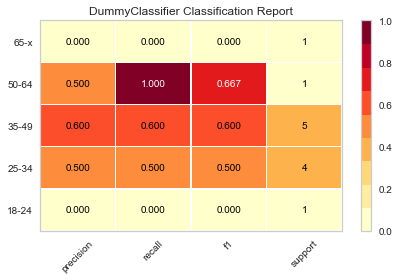

FINAL CALCULATIONS
Accuracy: 0.4166666666666667


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


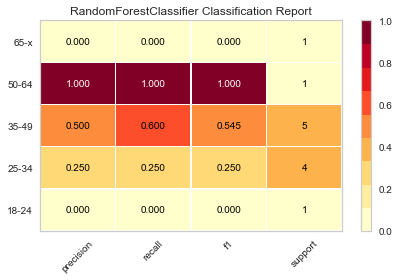

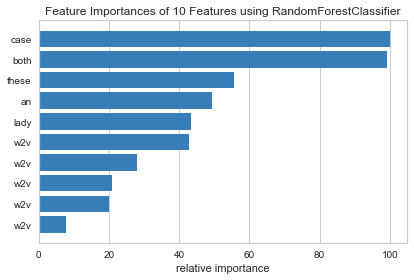

TIME PERIOD CALCULATIONS
RANDOM CALCULATIONS
Accuracy: 0.16666666666666666


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


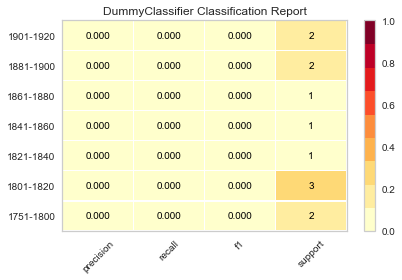

FINAL CALCULATIONS
Accuracy: 0.5833333333333334


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


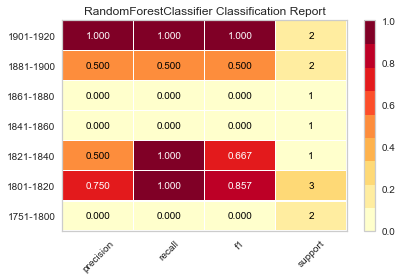

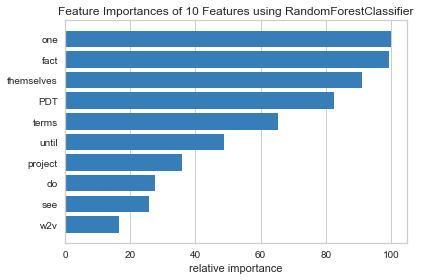

In [176]:
from random import randint
from sklearn.dummy import DummyClassifier
from yellowbrick.classifier import ClassPredictionError, ClassificationReport
from yellowbrick.features.importances import FeatureImportances
from numpy import append
import matplotlib.pyplot as plt
from yellowbrick.style import set_palette
    
# Palette only needs to be set globally once
# set_palette('set1') 

# Function to produce visualization of class prediction
# Runs into errors with unbalanced training/test sets, so left as comment
# def predict_class_error(model, test_features, test_labels, class_labels):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     plt.setp(ax.get_xticklabels(), rotation=30)
#     visualizer = ClassPredictionError(model, classes=class_labels, ax=ax)
#     print("Accuracy: %s" % visualizer.score(test_features, test_labels))
#     g = visualizer.poof()
    
# Function to produce visualization of metrics
def predict_metrics(model, test_features, test_labels, class_labels):
    fig = plt.figure()
    ax = fig.add_subplot()
    visualizer = ClassificationReport(model, classes=class_labels, support=True, ax=ax)
    print("Accuracy: %s" % visualizer.score(test_features, test_labels))
    g = visualizer.poof()
    
# Function to produce visualization of most important features in classifying novel
def predict_feature_importance(model, best_params, features, targets, feature_names):
    importances = model.feature_importances_
    importance_name_dict = {}
    feature_index_dict = {}
    
    # Initialize importance to name mappings and feature name to index mappings
    for i in range(0, len(feature_names)):
        importance_name_dict[importances[i]] = feature_names[i]
        feature_index_dict[feature_names[i]] = i
    
    # Sort list of importances to find ten with highest importances
    highest_importances = (sorted(importances, reverse = True))[0:10]
    highest_names = []
    highest_indexes = []
    
    # For every highest importance, find matching name in related map
    for importance in highest_importances:
        name = importance_name_dict[importance]
        highest_names.append(name)
        highest_indexes.append(feature_index_dict[name])
        
    # Remove all features except those with highest importance
    new_features = []
    for feature in features:
        new_feature = [feature[i] for i in highest_indexes]
        new_features.append(new_feature)
    
    # Fit new model with extracted features to highlight their importance
    new_model = get_model(best_age_params)
    fig = plt.figure()
    ax = fig.add_subplot()
    visualizer = FeatureImportances(new_model, ax=ax, labels=highest_names)
    visualizer.fit(new_features, targets)
    g = visualizer.poof()
    
# Use test datatset to return precision, recall, and f1 scores
print("AGE CALCULATIONS")
age_classes = ["18-24", "25-34", "35-49", "50-64", "65-x"]
test_age_features = testing_data_age[0]
test_age_labels = testing_data_age[1]
undropped_test_age_features = scale(scaler, test_age_features)
important_test_age_features = dropped_age_model.transform(undropped_test_age_features)

# Age predictions based on dummy classifier
print("RANDOM CALCULATIONS")
dummy_age_classifier = DummyClassifier()
trained_dummy_age_classifier = train_model(dummy_age_classifier, important_age_features, age_labels)
# predict_class_error(trained_dummy_age_classifier, important_test_age_features, test_age_labels, age_classes)
predict_metrics(trained_dummy_age_classifier, important_test_age_features, test_age_labels, age_classes)

# Age Predictions based on trained model
print("FINAL CALCULATIONS")
# predict_class_error(trained_age_model, important_test_age_features, test_age_labels, age_classes)
predict_metrics(trained_age_model, important_test_age_features, test_age_labels, age_classes)
predict_feature_importance(trained_age_model, best_age_params, important_age_features, age_labels, age_feature_names)

print("TIME PERIOD CALCULATIONS")
tp_classes = ["1751-1800", "1801-1820", "1821-1840", "1841-1860", "1861-1880", "1881-1900"]
test_tp_features = testing_data_time[0]
test_tp_labels = testing_data_time[1]
undropped_test_tp_features = scale(scaler, test_tp_features)
important_test_tp_features = dropped_tp_model.transform(undropped_test_tp_features)

# Time period prediction based on dummy classifier
print("RANDOM CALCULATIONS")
dummy_tp_classifier = DummyClassifier()
trained_dummy_tp_classifier = train_model(dummy_tp_classifier, important_tp_features, time_period_labels)
# predict_class_error(trained_dummy_tp_classifier, important_test_tp_features, test_tp_labels, tp_classes)
predict_metrics(trained_dummy_tp_classifier,important_test_tp_features, test_tp_labels, tp_classes)

# Time period prediction based on trained model
print("FINAL CALCULATIONS")
# predict_class_error(trained_tp_model, important_test_tp_features, test_tp_labels, tp_classes)
predict_metrics(trained_tp_model, important_test_tp_features, test_tp_labels, tp_classes)
predict_feature_importance(trained_tp_model, best_tp_params, important_tp_features, 
                           time_period_labels, time_feature_names)